# Solving the Incompressible Semi-Geostrophic Problem in 3D

First load in the required packages and paths.

In [1]:
import initialconditions as ic
import matplotlib.pyplot as plt
import numpy as np
import main as main

Next define the system parameters.

In [2]:
# Define the parameters of the system

box = [-3.66, -1.75, 0, 3.66, 1.75, 0.45] # List or tuple defining domain [xmin, ymin, zmin, xmax, ymax, zmax]
per_tol = 1e-3 # Percent tolerance
per_x = True # Set the periodicity of X
per_y = False # Set the periodicity of Y
per_z = False # Set the periodicity of Z
tf = 6 #52 # Final time
Ndt = 150 #1207 # Number of timesteps

Define the initial condition and visualise it.

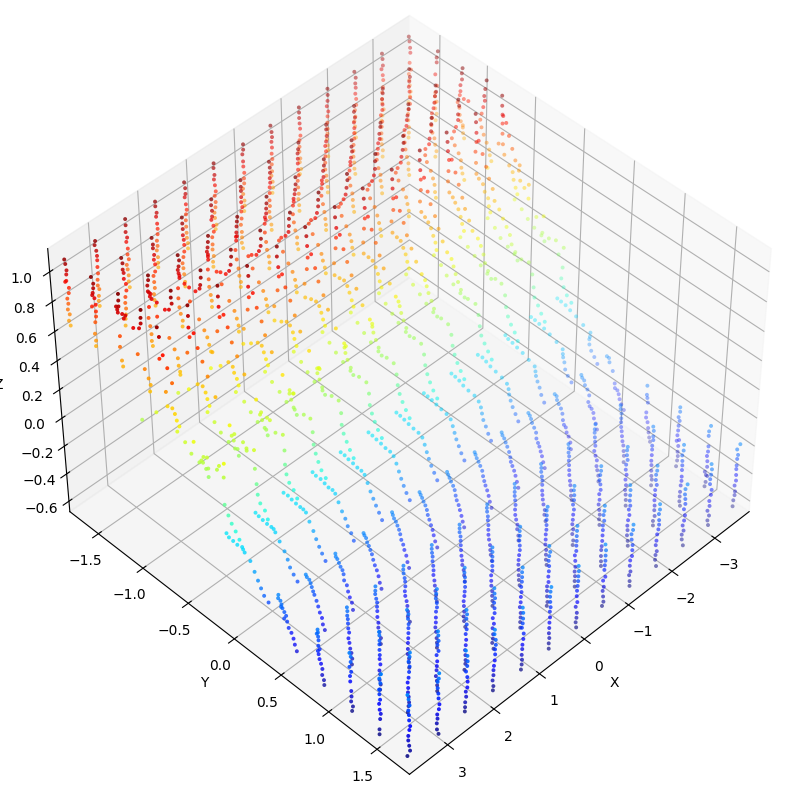

In [3]:
# Define the parameters and initialize an initial condition that is a perturbation of a steady background state

# N = 1000
# B = np.array([[1, 2, 3], [2, 4, 5], [3, 5, 6]]) #Create background steady state
# Z = ic.create_ss_initial(N, B, box, 'Thermal Sine') #Initial seed positions as a perturbation of a steady state

# Define the parameters and initialize an initial condition that is an isolated cyclone

N = 2197 # Number of seeds
A = 0 # Shear parameter can either be 0 or +/-0.1
Z = ic.create_cyc_initial(N, box, A, per_x, per_y, per_z, truncation = 16) #Initial seed positions for an isolated cyclone with no shear, shear can be set to +/-0.1

# Plot the initial condition

fig = plt.figure()
fig.set_size_inches(10, 10, True)
ax = fig.add_subplot(projection='3d')
ax.scatter(Z[:,0], Z[:,1], Z[:,2], c = Z[:,2], cmap = 'jet', edgecolor = 'none', s = 8) #Points colored based on their 3rd component i.e. temperature
ax.set_xlim([np.min(Z[:,0]), np.max(Z[:,0])])
ax.set_ylim([np.min(Z[:,1]), np.max(Z[:,1])])
ax.set_zlim([np.min(Z[:,2]), np.max(Z[:,2])])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev = 45, azim = 45) #Viewing angle on the inital conditions

plt.show()

Solve the problem and save the data

In [ ]:
main.SG_solver(box, Z, per_tol, tf, Ndt, per_x, per_y, per_z, debug = True) #Solve and save the solution 

#Can activate the optional variables solver, and debug to control which linear solver the code uses and whether or not the code is in debug mode.

# Animations

First animate the particles

In [ ]:
import animators as ani

# Animate the particles 

ani.point_animator('./data/SG_data.msgpack', 'C', '2D', box, tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
ani.point_animator('./data/SG_data.msgpack', 'C', '3D', box, tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
ani.point_animator('./data/SG_data.msgpack', 'Z', '2D', box, tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
ani.point_animator('./data/SG_data.msgpack', 'Z', '3D', box, tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'

Next load in the data to animate the cells

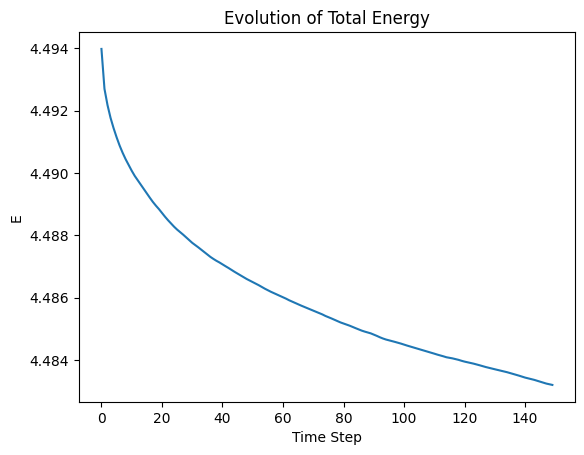

In [4]:
import auxfunctions as aux

# Load the data from the MessagePack file
Z, C, W, M, TC = aux.load_data('./data/SG_data.msgpack')

# Compute the Velocities, Temperature, and Kinetic Energy
MVel, ZVel, TVel, T, E, Eerr = aux.Properties(Z, C, TC)

# Create a line plot
plt.plot(E)
# Add labels and title
plt.xlabel('Time Step')
plt.ylabel('E')
plt.title('Evolution of Total Energy')

plt.show()

Next animate the cells

In [23]:
import optimaltransportsolver as ots
from pysdot import PowerDiagram
import pyvista as pv
import imageio.v2 as iio

#Animate the cells

coloring = 'Temp' # Chose how to colour the cells can be temperature ('Temp'), meridional velocity ('MVel'), zonal velocity ('ZVel'), or magnitude of total velocity ('TVel')
camera = 'Bottom' # Decide whether the camera is looking at the top or bottom of the domain

# Define a dictionary to map the coloring options to cell data attribute names
coloring_to_attr_name = {
    'Temp': 'Temperature',
    'MVel': 'Meridional Velocity',
    'ZVel': 'Zonal Velocity',
    'TVel': 'Magnitude of Total Velocity'
}

# Construct the domain
domain = ots.make_domain(box, False, False, False)

# Set up the animation parameters
n_frames = len(W)  # Number of frames

# Create an empty list to store frames
frames = []

# Generate frames for the animation
for i in range(n_frames):

    #Draw the tessellation
    pd = PowerDiagram(positions = Z[i] , weights = W[i] , domain = domain)

    # Save the results in a .vtk file
    filename = "./data/cells.vtk"
    pd.display_vtk(filename)

    # Store the volumes in an array
    if coloring == 'MVel':
        minval = np.min(MVel)
        maxval = np.max(MVel)
        colours = np.array(MVel[i])
    elif coloring == 'ZVel':
        minval = np.min(ZVel)
        maxval = np.max(ZVel)
        colours = np.array(ZVel[i])
    elif coloring == 'TVel':
        minval = np.min(TVel)
        maxval = np.max(TVel)
        colours = np.array(TVel[i])
    elif coloring == 'Temp':
        minval = np.min(T)
        maxval = np.max(T)
        colours = np.array(T[i])
    else:
        raise ValueError('Please specify how you want to colour the cells')

    # Read the data
    grid=pv.read(filename)

    # create cell data that gives the cell volumes, this allows us to colour by cell volumes
    cell_colours = colours[grid.cell_data['num'].astype(int)]
    grid.cell_data[coloring_to_attr_name[coloring]]=cell_colours

    # plot the data with an automatically created plotter, for a static picture use backend='static'
    plotter = pv.Plotter(window_size=[800,800], notebook = False, off_screen=True)
    plotter.add_mesh(grid, clim = [minval, maxval], cmap = 'jet')

    # Set the camera for a 2D view at either the bottom or the top
    if camera == 'Angled':
        pass
    elif camera == 'Top':
        plotter.camera_position = 'xy'
    elif camera == 'Bottom':
        plotter.camera_position = 'xy'
        plotter.camera.elevation = 180
        plotter.camera.roll += 360
    else:
        raise ValueError('Please specify how you want the camera oriented')

    # Render the frame
    plotter.show()

    # Get the frame as an image array
    frame = plotter.screenshot(transparent_background=True)

    # Add the frame to the list of frames
    frames.append(frame)

# Save the frames as an animation file
output_file = './animations/SG_Cells.gif'
iio.mimwrite(output_file, frames, format = 'gif', fps = 30)

# Combine and syncronize the animations

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image

# Function to read GIF frames
def read_gif(gif_path):
    img = Image.open(gif_path)
    frames = []
    try:
        while True:
            frames.append(img.copy())
            img.seek(len(frames))
    except EOFError:
        pass
    return frames

# Paths to your GIFs
gif1_path = './animations/SG_Cell_Animation.gif'
gif2_path = './animations/SG_Centroids_2D.gif'
gif3_path = './animations/SG_Seeds_2D.gif'

# Read GIF frames
frames1 = read_gif(gif1_path)
frames2 = read_gif(gif2_path)
frames3 = read_gif(gif3_path)

# Create a figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display each GIF on a separate subplot
ims = []

for ax, frames in zip(axes, [frames1, frames2, frames3]):
    im = ax.imshow(frames[0], animated=True)
    ims.append([im])

# Update function for the animation
def update(frame):
    for im, frames in zip(ims, [frames1, frames2, frames3]):
        im[0].set_array(frames[frame])

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(frames1), repeat=False, blit=False)

# Save the animation (uncomment the line below to save)
ani.save('./animations/Combined_Animation.gif', writer='pillow', fps=30)